# SetUp
* This R script was used and distributed during the ADVANCED DATA ANALYSIS FOR BIOLOGICAL PROCESSES Course
* We hope that it will be useful, but we do not provide ANY WARRANTY,
* not even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


In [1]:
setwd("/sharedFolder/Practical_1/")

In [2]:
suppressPackageStartupMessages({
    library("phyloseq")
    library(dplyr)
    library(tidyr)
    library(stringr)
    library(microbiome)
    library("microbial")
    library(vegan)
    library(usedist)
    library(ggplot2)
    library(nortest)
    library(car)
})

# Before we start, let's look at the files

## phyloseq object with the microbiome library 

In [3]:
otu <- read.table(file = "otu.csv", sep = ",", header = T, row.names = 1, check.names = FALSE)
taxa_present <- row.names(otu)
head(otu)
head(taxa_present)

,DISEASE_1,DISEASE_2,DISEASE_3,DISEASE_4,HEALTHY_1,HEALTHY_2,HEALTHY_3,HEALTHY_4,BLANK_1,BLANK_2,BLANK_3,BLANK_4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
OTU101,0,0,0,0,0,0,44,0,0,0,0,0
OTU1011,11,103,0,44,252,167,106,173,223,88,96,31
OTU105,0,0,0,0,0,0,39,0,0,0,0,0
OTU1052,0,0,0,0,32,0,0,0,0,0,0,121
OTU106,0,0,0,0,0,0,0,12,0,8,5,0
OTU1060,4,0,0,15,17,5,17,0,39,43,35,47


[1] "OTU101"  "OTU1011" "OTU105"  "OTU1052" "OTU106"  "OTU1060"

In [4]:
taxonomy <- read.table(file = "taxonomy.csv", sep = ",", header = T , row.names = 1)
head(taxonomy)

,Taxon
,<chr>
OTU101,k__Bacteria; p__Acidobacteria; c__Acidobacteria-6; o__iii1-15; f__Unknown_family; g__Unknown_genus403; s__Unknown_species1
OTU1011,k__Bacteria; p__Acidobacteria; c__DA052; o__Ellin6513; f__Unknown_family; g__Unknown_genus18; s__Unknown_species1
OTU105,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Corynebacteriaceae; g__Corynebacterium; s__Unknown_species1242
OTU1052,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Unknown_family; g__Unknown_genus425; s__Unknown_species1
OTU106,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Unknown_family; g__Unknown_genus580; s__Unknown_species1
OTU1060,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Unknown_family; g__Unknown_genus813; s__Unknown_species1


In [5]:
# clean the taxonomy, Greengenes format
tax <- taxonomy %>%
  select(Taxon) %>% 
  separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), "; ")

head(tax)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
OTU101,k__Bacteria,p__Acidobacteria,c__Acidobacteria-6,o__iii1-15,f__Unknown_family,g__Unknown_genus403,s__Unknown_species1
OTU1011,k__Bacteria,p__Acidobacteria,c__DA052,o__Ellin6513,f__Unknown_family,g__Unknown_genus18,s__Unknown_species1
OTU105,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Corynebacteriaceae,g__Corynebacterium,s__Unknown_species1242
OTU1052,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus425,s__Unknown_species1
OTU106,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus580,s__Unknown_species1
OTU1060,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus813,s__Unknown_species1


In [6]:
tax.clean <- data.frame(row.names = row.names(tax),
                        Kingdom = str_replace(tax[,1], "k__",""),
                        Phylum = str_replace(tax[,2], "p__",""),
                        Class = str_replace(tax[,3], "c__",""),
                        Order = str_replace(tax[,4], "o__",""),
                        Family = str_replace(tax[,5], "f__",""),
                        Genus = str_replace(tax[,6], "g__",""),
                        Species = str_replace(tax[,7], "s__",""),
                        stringsAsFactors = FALSE)

In [7]:
tax.clean[is.na(tax.clean)] <- ""
tax.clean[tax.clean=="__"] <- ""
head(tax.clean)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
OTU101,Bacteria,Acidobacteria,Acidobacteria-6,iii1-15,Unknown_family,Unknown_genus403,Unknown_species1
OTU1011,Bacteria,Acidobacteria,DA052,Ellin6513,Unknown_family,Unknown_genus18,Unknown_species1
OTU105,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,Unknown_species1242
OTU1052,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Unknown_family,Unknown_genus425,Unknown_species1
OTU106,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Unknown_family,Unknown_genus580,Unknown_species1
OTU1060,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Unknown_family,Unknown_genus813,Unknown_species1


In [8]:
for (i in 1:nrow(tax.clean)){
  if (tax.clean[i,7] != ""){
    tax.clean$Species[i] <- paste(tax.clean$Genus[i], tax.clean$Species[i], sep = " ")
  } else if (tax.clean[i,2] == ""){
    kingdom <- paste("Unclassified", tax.clean[i,1], sep = " ")
    tax.clean[i, 2:7] <- kingdom
  } else if (tax.clean[i,3] == ""){
    phylum <- paste("Unclassified", tax.clean[i,2], sep = " ")
    tax.clean[i, 3:7] <- phylum
  } else if (tax.clean[i,4] == ""){
    class <- paste("Unclassified", tax.clean[i,3], sep = " ")
    tax.clean[i, 4:7] <- class
  } else if (tax.clean[i,5] == ""){
    order <- paste("Unclassified", tax.clean[i,4], sep = " ")
    tax.clean[i, 5:7] <- order
  } else if (tax.clean[i,6] == ""){
    family <- paste("Unclassified", tax.clean[i,5], sep = " ")
    tax.clean[i, 6:7] <- family
  } else if (tax.clean[i,7] == ""){
    tax.clean$Species[i] <- paste("Unclassified ", tax.clean$Genus[i], sep = " ")
  }
}

In [9]:
head(tax)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
OTU101,k__Bacteria,p__Acidobacteria,c__Acidobacteria-6,o__iii1-15,f__Unknown_family,g__Unknown_genus403,s__Unknown_species1
OTU1011,k__Bacteria,p__Acidobacteria,c__DA052,o__Ellin6513,f__Unknown_family,g__Unknown_genus18,s__Unknown_species1
OTU105,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Corynebacteriaceae,g__Corynebacterium,s__Unknown_species1242
OTU1052,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus425,s__Unknown_species1
OTU106,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus580,s__Unknown_species1
OTU1060,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus813,s__Unknown_species1


In [10]:
metadata <- read.table(file = "metadata.csv", sep = ",", header = T, row.names = 1)
head(metadata)

,Status,Condition
,<chr>,<chr>
DISEASE_1,DISEASE,NO_BLANK
DISEASE_2,DISEASE,NO_BLANK
DISEASE_3,DISEASE,NO_BLANK
DISEASE_4,DISEASE,NO_BLANK
HEALTHY_1,HEALTHY,NO_BLANK
HEALTHY_2,HEALTHY,NO_BLANK


In [11]:
OTU = otu_table(as.matrix(otu), taxa_are_rows = TRUE)
head(OTU)

,DISEASE_1,DISEASE_2,DISEASE_3,DISEASE_4,HEALTHY_1,HEALTHY_2,HEALTHY_3,HEALTHY_4,BLANK_1,BLANK_2,BLANK_3,BLANK_4
OTU101,0,0,0,0,0,0,44,0,0,0,0,0
OTU1011,11,103,0,44,252,167,106,173,223,88,96,31
OTU105,0,0,0,0,0,0,39,0,0,0,0,0
OTU1052,0,0,0,0,32,0,0,0,0,0,0,121
OTU106,0,0,0,0,0,0,0,12,0,8,5,0
OTU1060,4,0,0,15,17,5,17,0,39,43,35,47


In [12]:
TAX = tax_table(as.matrix(tax))
head(TAX)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU101,k__Bacteria,p__Acidobacteria,c__Acidobacteria-6,o__iii1-15,f__Unknown_family,g__Unknown_genus403,s__Unknown_species1
OTU1011,k__Bacteria,p__Acidobacteria,c__DA052,o__Ellin6513,f__Unknown_family,g__Unknown_genus18,s__Unknown_species1
OTU105,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Corynebacteriaceae,g__Corynebacterium,s__Unknown_species1242
OTU1052,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus425,s__Unknown_species1
OTU106,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus580,s__Unknown_species1
OTU1060,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Unknown_family,g__Unknown_genus813,s__Unknown_species1


In [13]:
SAMPLE <- sample_data(metadata)
SAMPLE[,]

,Status,Condition
,<chr>,<chr>
DISEASE_1,DISEASE,NO_BLANK
DISEASE_2,DISEASE,NO_BLANK
DISEASE_3,DISEASE,NO_BLANK
DISEASE_4,DISEASE,NO_BLANK
HEALTHY_1,HEALTHY,NO_BLANK
HEALTHY_2,HEALTHY,NO_BLANK
HEALTHY_3,HEALTHY,NO_BLANK
HEALTHY_4,HEALTHY,NO_BLANK
BLANK_1,BLANK,BLANK


In [14]:
# merge the data into a Phyloseq Object
ps <- phyloseq(OTU, TAX, SAMPLE)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 966 taxa and 12 samples ]
sample_data() Sample Data:       [ 12 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 966 taxa by 7 taxonomic ranks ]

# plot relative abundance

##  library - microbial

In [15]:
##  Selection by metadata
psbar1 <- subset_samples(ps, Status=="HEALTHY" | Status == "BLANK")
metabar1 <- data.frame(sample_data(psbar1))
metabar1

,Status,Condition
,<chr>,<chr>
HEALTHY_1,HEALTHY,NO_BLANK
HEALTHY_2,HEALTHY,NO_BLANK
HEALTHY_3,HEALTHY,NO_BLANK
HEALTHY_4,HEALTHY,NO_BLANK
BLANK_1,BLANK,BLANK
BLANK_2,BLANK,BLANK
BLANK_3,BLANK,BLANK
BLANK_4,BLANK,BLANK


In [16]:
#to find taxa that are "really" present in the considered subsection of samples 
dat = psbar1@otu_table[!apply(psbar1@otu_table, 1, function(x) all(x == 0)), ]
real_taxa <- row.names(dat@.Data)
head(real_taxa)
psbar2_otu <- psbar1@otu_table[c(real_taxa),]
psbar2_taxa <- psbar1@tax_table[c(real_taxa),]
SAMPLE1 <- sample_data(metabar1)
psbar_obj <- phyloseq(psbar2_otu, psbar2_taxa, SAMPLE1)
psbar_obj

[1] "OTU101"  "OTU1011" "OTU105"  "OTU1052" "OTU106"  "OTU1060"

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 801 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 801 taxa by 7 taxonomic ranks ]

In [17]:
##  check for the function "normalize"
##        which method? 
##  method = "relative" argument, calculates relative abundances, which are the proportions of each feature 
##  (like OTUs or ASVs) within a sample. 
##  This method converts raw counts into percentages by dividing each feature's count by the total count 

In [18]:
##  for that sample
phy <- normalize(psbar_obj)

Normalization using relative method 



Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the microbial package.
  Please report the issue to the authors.”


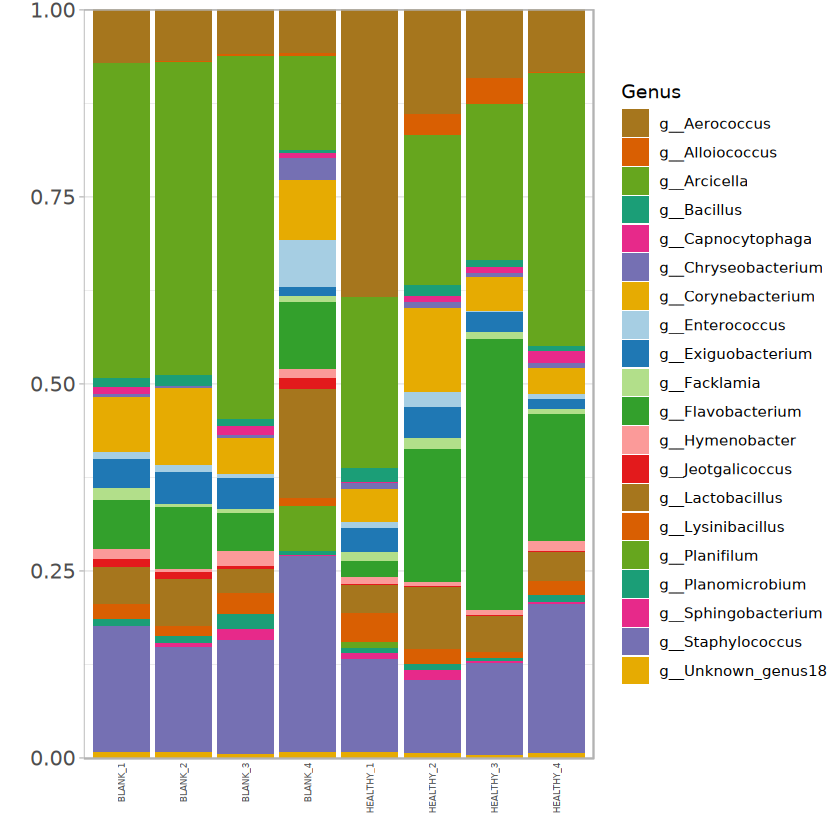

In [19]:
##  plot by samples
plotbar(phy, level="Genus", top = 20)

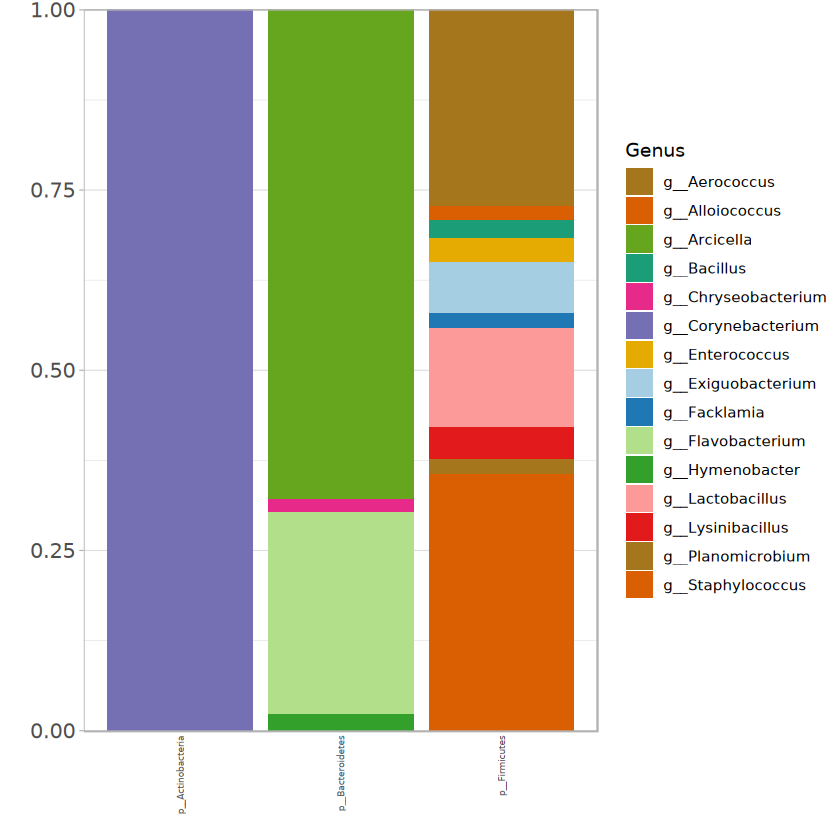

In [20]:
##  plot by taxonomical leyer
plotbar(phy, level="Genus", top = 15, group = "Phylum")

In [21]:
##  try with other taxonomical leyers: Class, Family, etx

#var1 <- plotbar(phy, level="Species", top = 15, group = "Phylum", return = T)
#head(var1)

#    ALPHAs & BETAs with microbiome library

##    ALPHAs

In [22]:
alpha <-microbiome::alpha(ps, index = "all")
head(alpha)

Observed richness

Other forms of richness

Diversity

Evenness

Dominance

Rarity



,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_fisher,diversity_coverage,evenness_camargo,evenness_pielou,evenness_simpson,⋯,dominance_dbp,dominance_dmn,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DISEASE_1,224,224.000,30.034810,0.96670530,4.2314616,34.085270,11,0.4946452,0.78191766,0.13408397,⋯,0.1145371,0.1937593,2786,0.1145371,0.03329470,0.08325111,0.9359701,2.061396,0.11593488,0.834320013
DISEASE_2,237,237.125,6.718725,0.85116224,3.0800671,34.016836,3,0.4435090,0.56328332,0.02834905,⋯,0.3294698,0.4935670,11882,0.3294698,0.14883776,0.44290705,0.9643324,2.061352,0.12638642,0.502606477
DISEASE_3,49,49.000,1.027580,0.02683937,0.1173068,4.935205,1,0.9979732,0.03014189,0.02097101,⋯,0.9864844,0.9884208,99848,0.9864844,0.97316063,0.99032762,0.9986290,2.060839,0.01351565,0.007301217
DISEASE_4,237,237.000,2.498256,0.59972076,2.1646418,32.173348,1,0.8853422,0.39587016,0.01054116,⋯,0.6253711,0.7071627,31807,0.6253711,0.40027924,0.21474214,0.9736683,2.061375,0.11694619,0.745561432
HEALTHY_1,258,258.000,6.187914,0.83839464,3.0948937,36.559328,2,0.7299785,0.55734129,0.02398416,⋯,0.3387804,0.5422562,14367,0.3387804,0.16160536,0.75582437,0.9593375,2.061382,0.13714394,0.164167138
HEALTHY_2,289,289.200,19.509541,0.94874303,4.1388815,42.665547,10,0.5868802,0.73042179,0.06750706,⋯,0.1674940,0.2816164,6242,0.1674940,0.05125697,0.49636408,0.9265585,2.061391,0.17345104,0.328065044


In [23]:
aa <- merge(alpha, metadata, 
            by = 'row.names', all = TRUE) 
head(aa)

,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_fisher,diversity_coverage,evenness_camargo,evenness_pielou,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,BLANK_1,196,196.500,6.507532,0.8463319,3.275834,27.67471,4,0.5394110,0.6206448,⋯,12388,0.37626048,0.15366809,0.67667963,0.9618133,2.061387,0.09807435,0.1952679,BLANK,BLANK
2,BLANK_2,183,184.200,6.451069,0.8449869,3.230167,25.67552,4,0.5534409,0.6200548,⋯,12038,0.37669368,0.15501308,0.68222925,0.9628243,2.061382,0.09112245,0.2461433,BLANK,BLANK
3,BLANK_3,158,159.000,5.396675,0.8147007,3.144660,22.97308,3,0.4929293,0.6211558,⋯,9351,0.41992994,0.18529928,0.67055865,0.9637944,2.061368,0.07270523,0.2080115,BLANK,BLANK
4,BLANK_4,278,278.000,35.281113,0.9716562,4.464470,40.52005,13,0.7490272,0.7933139,⋯,3781,0.09790011,0.02834378,0.34548562,0.9140507,2.061262,0.14766578,0.5806427,BLANK,BLANK
5,DISEASE_1,224,224.000,30.034810,0.9667053,4.231462,34.08527,11,0.4946452,0.7819177,⋯,2786,0.11453708,0.03329470,0.08325111,0.9359701,2.061396,0.11593488,0.8343200,DISEASE,NO_BLANK
6,DISEASE_2,237,237.125,6.718725,0.8511622,3.080067,34.01684,3,0.4435090,0.5632833,⋯,11882,0.32946983,0.14883776,0.44290705,0.9643324,2.061352,0.12638642,0.5026065,DISEASE,NO_BLANK


In [24]:
# Use relative abundance data
ps1 <- microbiome::transform(ps, "compositional")

In [25]:
# Pick core taxa
ps1 <- core(ps1, detection = 0.001, prevalence = 60/100)

In [26]:
### detection = 0  this sets the minimum abundance threshold.
### 0 means that a taxon is considered “detected” even if it appears at any nonzero abundance.

In [27]:
### prevalence = 60/100  this sets the prevalence threshold, i.e. the minimum fraction of samples in which a taxon must be detected to be considered part of the core.
### 60/100 = 0.6, meaning taxa must appear in at least 60% of the samples.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
ℹ The deprecated feature was likely used in the microbiome package.
  Please report the issue at <https://github.com/microbiome/microbiome/issues>.”


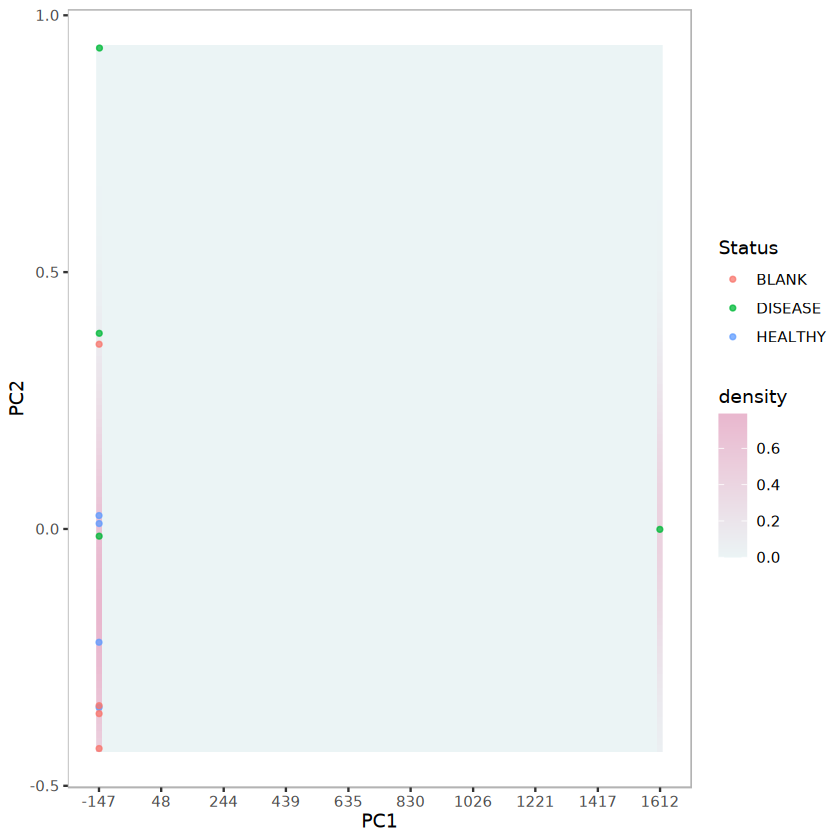

In [28]:
# Illustrate sample similarities with PCoA (NMDS)
plot_landscape(ps1, "NMDS", "bray", col = "Status")

In [29]:
head(ps@otu_table)
head(ps1@otu_table)

,DISEASE_1,DISEASE_2,DISEASE_3,DISEASE_4,HEALTHY_1,HEALTHY_2,HEALTHY_3,HEALTHY_4,BLANK_1,BLANK_2,BLANK_3,BLANK_4
OTU101,0,0,0,0,0,0,44,0,0,0,0,0
OTU1011,11,103,0,44,252,167,106,173,223,88,96,31
OTU105,0,0,0,0,0,0,39,0,0,0,0,0
OTU1052,0,0,0,0,32,0,0,0,0,0,0,121
OTU106,0,0,0,0,0,0,0,12,0,8,5,0
OTU1060,4,0,0,15,17,5,17,0,39,43,35,47


,DISEASE_1,DISEASE_2,DISEASE_3,DISEASE_4,HEALTHY_1,HEALTHY_2,HEALTHY_3,HEALTHY_4,BLANK_1,BLANK_2,BLANK_3,BLANK_4
OTU1011,0.0004522283,0.0028560337,0.0000000000,0.0008651029,0.005942275,0.004481176,0.002132711,0.004754968,0.006773175,0.002753700,0.004311119,0.0008026721
OTU1101,0.0386860714,0.1640971606,0.0019364527,0.0817915495,0.203475759,0.167494030,0.181662710,0.321276420,0.376260479,0.376693682,0.419929944,0.0979001062
OTU1191,0.0000000000,0.0002772848,0.0000000000,0.0007864572,0.003277683,0.001261169,0.003219186,0.006541517,0.004252217,0.002565948,0.004760194,0.0011910619
OTU1423,0.0000000000,0.0079026176,0.0000000000,0.0019858044,0.000000000,0.003917675,0.006297533,0.014484787,0.008595553,0.000000000,0.010418538,0.0024856943
OTU1737,0.0003288933,0.0088176575,0.0006125514,0.0014942687,0.004102999,0.033112405,0.235322522,0.110161339,0.026090390,0.011578058,0.003143524,0.0013723104
OTU310,0.0004111166,0.0021905501,0.0000000000,0.0021824187,0.008111677,0.004025009,0.004788540,0.003820466,0.004890050,0.006320994,0.005164361,0.0037026488


## HEALTHY_HAIR or HEALTHY_CSF and NO_BLANK

In [30]:
xx <- subset(aa, Condition =="NO_BLANK")
head(xx)
tail(xx)

,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_fisher,diversity_coverage,evenness_camargo,evenness_pielou,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
5,DISEASE_1,224,224.000,30.034810,0.96670530,4.2314616,34.085270,11,0.4946452,0.78191766,⋯,2786,0.1145371,0.03329470,0.08325111,0.9359701,2.061396,0.11593488,0.834320013,DISEASE,NO_BLANK
6,DISEASE_2,237,237.125,6.718725,0.85116224,3.0800671,34.016836,3,0.4435090,0.56328332,⋯,11882,0.3294698,0.14883776,0.44290705,0.9643324,2.061352,0.12638642,0.502606477,DISEASE,NO_BLANK
7,DISEASE_3,49,49.000,1.027580,0.02683937,0.1173068,4.935205,1,0.9979732,0.03014189,⋯,99848,0.9864844,0.97316063,0.99032762,0.9986290,2.060839,0.01351565,0.007301217,DISEASE,NO_BLANK
8,DISEASE_4,237,237.000,2.498256,0.59972076,2.1646418,32.173348,1,0.8853422,0.39587016,⋯,31807,0.6253711,0.40027924,0.21474214,0.9736683,2.061375,0.11694619,0.745561432,DISEASE,NO_BLANK
9,HEALTHY_1,258,258.000,6.187914,0.83839464,3.0948937,36.559328,2,0.7299785,0.55734129,⋯,14367,0.3387804,0.16160536,0.75582437,0.9593375,2.061382,0.13714394,0.164167138,HEALTHY,NO_BLANK
10,HEALTHY_2,289,289.200,19.509541,0.94874303,4.1388815,42.665547,10,0.5868802,0.73042179,⋯,6242,0.1674940,0.05125697,0.49636408,0.9265585,2.061391,0.17345104,0.328065044,HEALTHY,NO_BLANK


,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_fisher,diversity_coverage,evenness_camargo,evenness_pielou,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7,DISEASE_3,49,49.0,1.027580,0.02683937,0.1173068,4.935205,1,0.9979732,0.03014189,⋯,99848,0.9864844,0.97316063,0.9903276,0.9986290,2.060839,0.01351565,0.007301217,DISEASE,NO_BLANK
8,DISEASE_4,237,237.0,2.498256,0.59972076,2.1646418,32.173348,1,0.8853422,0.39587016,⋯,31807,0.6253711,0.40027924,0.2147421,0.9736683,2.061375,0.11694619,0.745561432,DISEASE,NO_BLANK
9,HEALTHY_1,258,258.0,6.187914,0.83839464,3.0948937,36.559328,2,0.7299785,0.55734129,⋯,14367,0.3387804,0.16160536,0.7558244,0.9593375,2.061382,0.13714394,0.164167138,HEALTHY,NO_BLANK
10,HEALTHY_2,289,289.2,19.509541,0.94874303,4.1388815,42.665547,10,0.5868802,0.73042179,⋯,6242,0.1674940,0.05125697,0.4963641,0.9265585,2.061391,0.17345104,0.328065044,HEALTHY,NO_BLANK
11,HEALTHY_3,233,233.0,9.939775,0.89939410,3.4309010,31.660303,4,0.4775319,0.62940320,⋯,11696,0.2353225,0.10060590,0.6794495,0.9567662,2.061349,0.14528590,0.224457768,HEALTHY,NO_BLANK
12,HEALTHY_4,172,172.0,7.754238,0.87103826,3.2379803,23.402445,3,0.6049407,0.62904006,⋯,11689,0.3212764,0.12896174,0.7324300,0.9650276,2.060951,0.09457714,0.191078251,HEALTHY,NO_BLANK


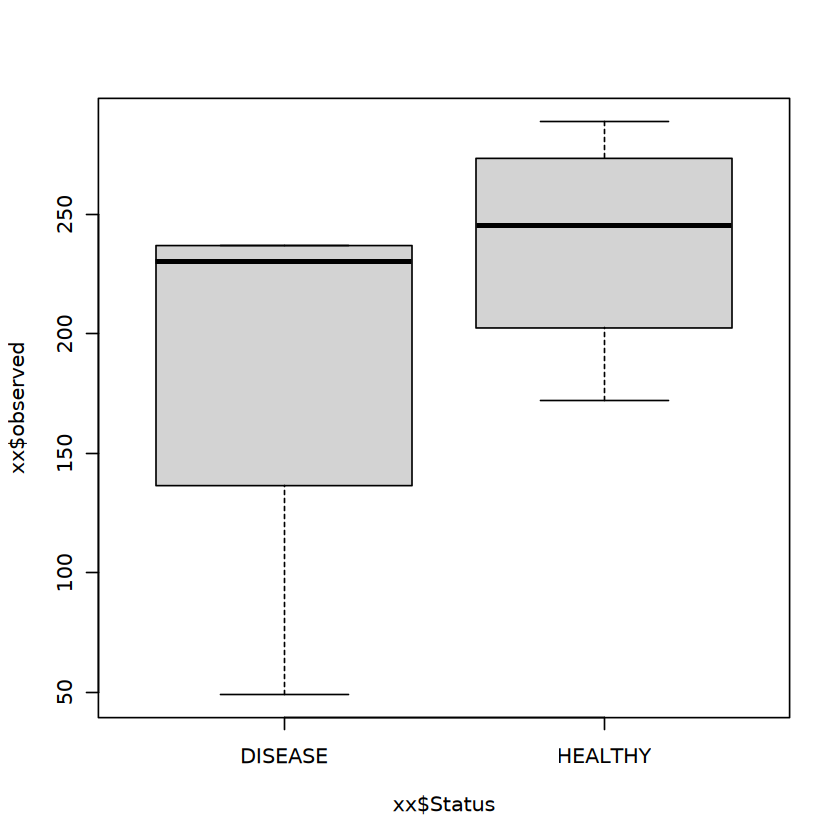

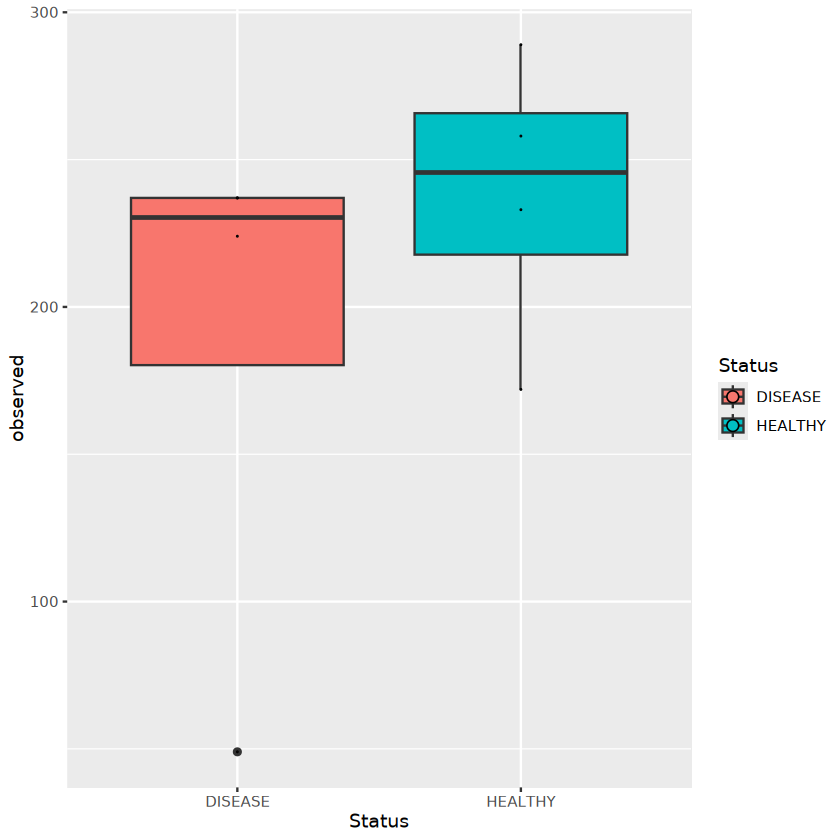

In [31]:
### observed
suppressMessages(suppressWarnings({
    wilcox.test(xx$observed ~ xx$Status)
    boxplot(xx$observed ~ xx$Status)
}))
ggplot(xx, aes(x=Status, y=observed, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center', binwidth = diff(range(xx$diversity_shannon, na.rm = TRUE)) / 30 )


	Wilcoxon rank sum exact test

data:  xx$diversity_shannon by xx$Status
W = 4, p-value = 0.3429
alternative hypothesis: true location shift is not equal to 0


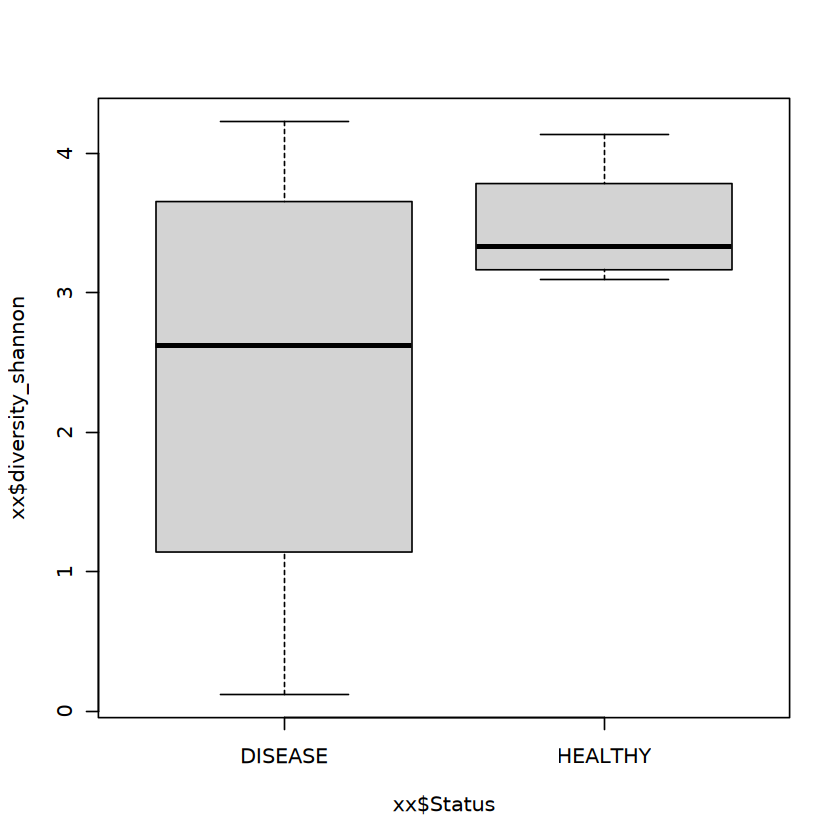

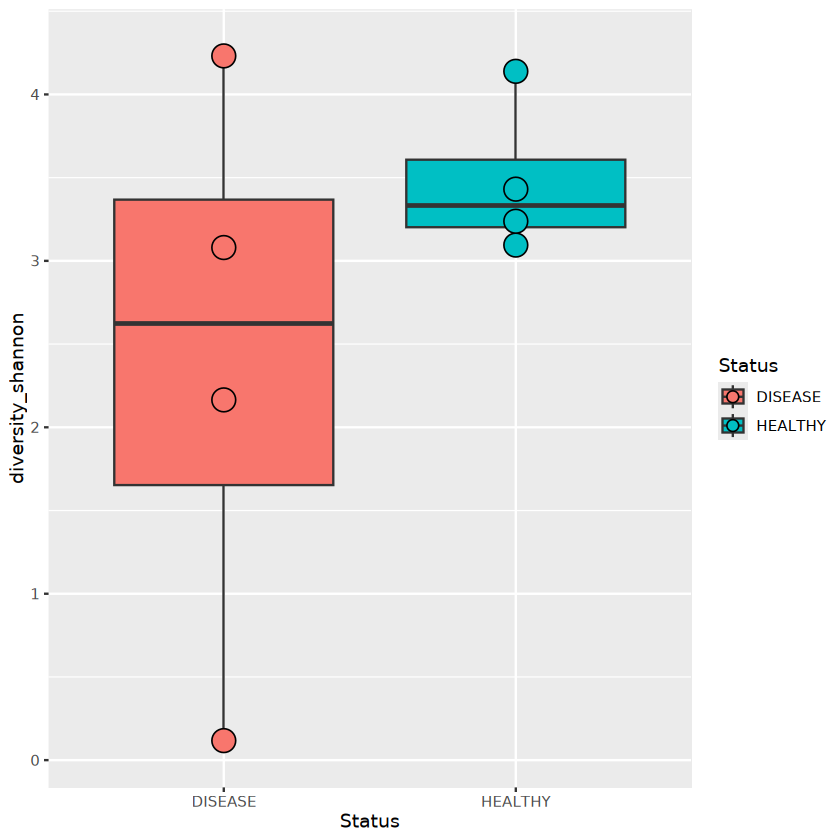

In [32]:
### diversity_shannon
wilcox.test(xx$diversity_shannon ~ xx$Status)
boxplot(xx$diversity_shannon ~ xx$Status)
ggplot(xx, aes(x=Status, y=diversity_shannon, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center', binwidth = diff(range(xx$diversity_shannon, na.rm = TRUE)) / 30 )


	Wilcoxon rank sum exact test

data:  xx$diversity_inverse_simpson by xx$Status
W = 5, p-value = 0.4857
alternative hypothesis: true location shift is not equal to 0


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


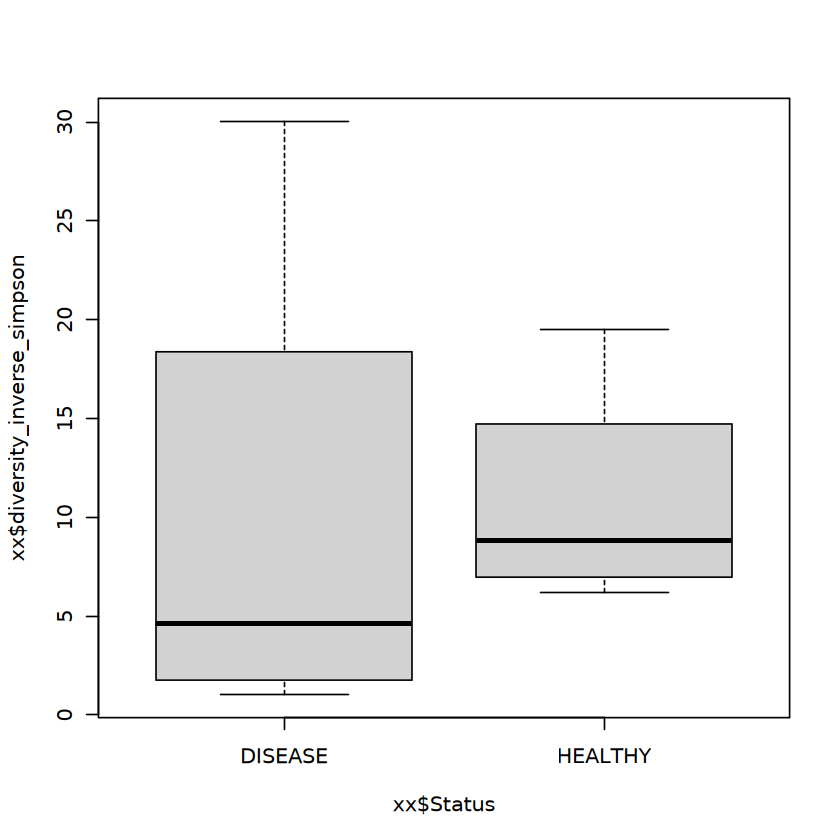

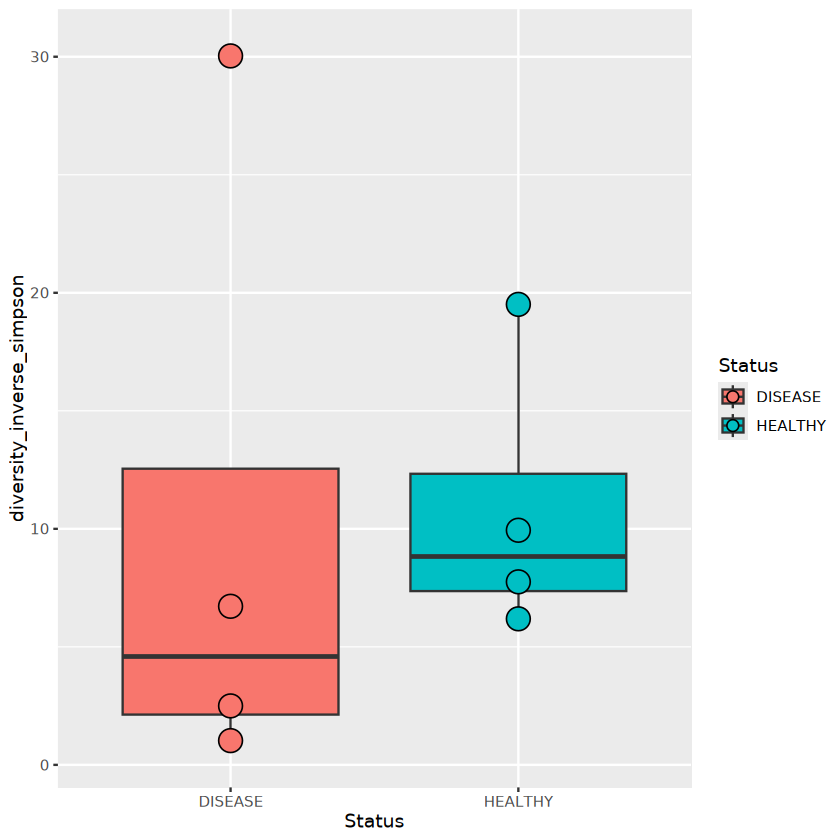

In [33]:
### diversity_inverse_simpson
wilcox.test(xx$diversity_inverse_simpson ~ xx$Status)
boxplot(xx$diversity_inverse_simpson ~ xx$Status)
ggplot(xx, aes(x=Status, y=diversity_inverse_simpson, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center')

# Question: run the statistics without excluding any sample
* which is the test?
* kruskal.test(A ~ B, data = data)
* pairwise.wilcox.test(`data$A`, `data$B`, p.adjust.method = "BH")

## ALPHA on COMPOSITIONAL DATA

In [34]:
ps_c <- microbiome::transform(ps, "compositional")
alpha_c <-microbiome::alpha(ps_c, index = "all")
head(alpha_c)

Observed richness

Other forms of richness

Diversity

Warning message in diversities_help(x, index = idx, zeroes = TRUE):
“Fisher diversity defined only for integers; 
            the OTU table contains non-integers. Fisher not estimated.”
Evenness

Dominance

Rarity



,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_coverage,evenness_camargo,evenness_pielou,evenness_simpson,evenness_evar,⋯,dominance_dbp,dominance_dmn,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DISEASE_1,224,224,30.034810,0.96670530,4.2314616,11,0.4946452,0.78191766,0.13408397,0.3078668,⋯,0.1145371,0.1937593,0.1145371,0.1145371,0.03329470,0.08325111,0.9359701,2.059840,0.11593488,0.834320013
DISEASE_2,237,237,6.718725,0.85116224,3.0800671,3,0.4435090,0.56328332,0.02834905,0.3045524,⋯,0.3294698,0.4935670,0.3294698,0.3294698,0.14883776,0.44290705,0.9643324,2.060954,0.12638642,0.502606477
DISEASE_3,49,49,1.027580,0.02683937,0.1173068,1,0.9979732,0.03014189,0.02097101,0.2476670,⋯,0.9864844,0.9884208,0.9864844,0.9864844,0.97316063,0.99032762,0.9986290,2.060839,0.01351565,0.007301217
DISEASE_4,237,237,2.498256,0.59972076,2.1646418,1,0.8853422,0.39587016,0.01054116,0.3316111,⋯,0.6253711,0.7071627,0.6253711,0.6253711,0.40027924,0.21474214,0.9736683,2.061352,0.11694619,0.745561432
HEALTHY_1,258,258,6.187914,0.83839464,3.0948937,2,0.7299785,0.55734129,0.02398416,0.3033624,⋯,0.3387804,0.5422562,0.3387804,0.3387804,0.16160536,0.75582437,0.9593375,2.060617,0.13714394,0.164167138
HEALTHY_2,289,289,19.509541,0.94874303,4.1388815,10,0.5868802,0.73042179,0.06750706,0.3324804,⋯,0.1674940,0.2816164,0.1674940,0.1674940,0.05125697,0.49636408,0.9265585,2.060768,0.17345104,0.328065044


In [35]:
aa_c <- merge(alpha_c, metadata, 
              by = 'row.names', all = TRUE) 
head(aa_c)

,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_coverage,evenness_camargo,evenness_pielou,evenness_simpson,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,BLANK_1,196,196,6.507532,0.8463319,3.275834,4,0.5394110,0.6206448,0.03320169,⋯,0.37626048,0.37626048,0.15366809,0.67667963,0.9618133,2.060652,0.09807435,0.1952679,BLANK,BLANK
2,BLANK_2,183,183,6.451069,0.8449869,3.230167,4,0.5534409,0.6200548,0.03525174,⋯,0.37669368,0.37669368,0.15501308,0.68222925,0.9628243,2.060621,0.09112245,0.2461433,BLANK,BLANK
3,BLANK_3,158,158,5.396675,0.8147007,3.144660,3,0.4929293,0.6211558,0.03415617,⋯,0.41992994,0.41992994,0.18529928,0.67055865,0.9637944,2.060631,0.07270523,0.2080115,BLANK,BLANK
4,BLANK_4,278,278,35.281113,0.9716562,4.464470,13,0.7490272,0.7933139,0.12691048,⋯,0.09790011,0.09790011,0.02834378,0.34548562,0.9140507,2.060658,0.14766578,0.5806427,BLANK,BLANK
5,DISEASE_1,224,224,30.034810,0.9667053,4.231462,11,0.4946452,0.7819177,0.13408397,⋯,0.11453708,0.11453708,0.03329470,0.08325111,0.9359701,2.059840,0.11593488,0.8343200,DISEASE,NO_BLANK
6,DISEASE_2,237,237,6.718725,0.8511622,3.080067,3,0.4435090,0.5632833,0.02834905,⋯,0.32946983,0.32946983,0.14883776,0.44290705,0.9643324,2.060954,0.12638642,0.5026065,DISEASE,NO_BLANK


## HEALTHY_HAIR or HEALTHY_CSF and NO_BLANK

In [36]:
xx_c <- subset(aa_c, Condition =="NO_BLANK")
head(xx_c)
tail(xx_c)

,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_coverage,evenness_camargo,evenness_pielou,evenness_simpson,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
5,DISEASE_1,224,224,30.034810,0.96670530,4.2314616,11,0.4946452,0.78191766,0.13408397,⋯,0.1145371,0.1145371,0.03329470,0.08325111,0.9359701,2.059840,0.11593488,0.834320013,DISEASE,NO_BLANK
6,DISEASE_2,237,237,6.718725,0.85116224,3.0800671,3,0.4435090,0.56328332,0.02834905,⋯,0.3294698,0.3294698,0.14883776,0.44290705,0.9643324,2.060954,0.12638642,0.502606477,DISEASE,NO_BLANK
7,DISEASE_3,49,49,1.027580,0.02683937,0.1173068,1,0.9979732,0.03014189,0.02097101,⋯,0.9864844,0.9864844,0.97316063,0.99032762,0.9986290,2.060839,0.01351565,0.007301217,DISEASE,NO_BLANK
8,DISEASE_4,237,237,2.498256,0.59972076,2.1646418,1,0.8853422,0.39587016,0.01054116,⋯,0.6253711,0.6253711,0.40027924,0.21474214,0.9736683,2.061352,0.11694619,0.745561432,DISEASE,NO_BLANK
9,HEALTHY_1,258,258,6.187914,0.83839464,3.0948937,2,0.7299785,0.55734129,0.02398416,⋯,0.3387804,0.3387804,0.16160536,0.75582437,0.9593375,2.060617,0.13714394,0.164167138,HEALTHY,NO_BLANK
10,HEALTHY_2,289,289,19.509541,0.94874303,4.1388815,10,0.5868802,0.73042179,0.06750706,⋯,0.1674940,0.1674940,0.05125697,0.49636408,0.9265585,2.060768,0.17345104,0.328065044,HEALTHY,NO_BLANK


,Row.names,observed,chao1,diversity_inverse_simpson,diversity_gini_simpson,diversity_shannon,diversity_coverage,evenness_camargo,evenness_pielou,evenness_simpson,⋯,dominance_absolute,dominance_relative,dominance_simpson,dominance_core_abundance,dominance_gini,rarity_log_modulo_skewness,rarity_low_abundance,rarity_rare_abundance,Status,Condition
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7,DISEASE_3,49,49,1.027580,0.02683937,0.1173068,1,0.9979732,0.03014189,0.02097101,⋯,0.9864844,0.9864844,0.97316063,0.9903276,0.9986290,2.060839,0.01351565,0.007301217,DISEASE,NO_BLANK
8,DISEASE_4,237,237,2.498256,0.59972076,2.1646418,1,0.8853422,0.39587016,0.01054116,⋯,0.6253711,0.6253711,0.40027924,0.2147421,0.9736683,2.061352,0.11694619,0.745561432,DISEASE,NO_BLANK
9,HEALTHY_1,258,258,6.187914,0.83839464,3.0948937,2,0.7299785,0.55734129,0.02398416,⋯,0.3387804,0.3387804,0.16160536,0.7558244,0.9593375,2.060617,0.13714394,0.164167138,HEALTHY,NO_BLANK
10,HEALTHY_2,289,289,19.509541,0.94874303,4.1388815,10,0.5868802,0.73042179,0.06750706,⋯,0.1674940,0.1674940,0.05125697,0.4963641,0.9265585,2.060768,0.17345104,0.328065044,HEALTHY,NO_BLANK
11,HEALTHY_3,233,233,9.939775,0.89939410,3.4309010,4,0.4775319,0.62940320,0.04265998,⋯,0.2353225,0.2353225,0.10060590,0.6794495,0.9567662,2.060402,0.14528590,0.224457768,HEALTHY,NO_BLANK
12,HEALTHY_4,172,172,7.754238,0.87103826,3.2379803,3,0.6049407,0.62904006,0.04508278,⋯,0.3212764,0.3212764,0.12896174,0.7324300,0.9650276,2.060713,0.09457714,0.191078251,HEALTHY,NO_BLANK


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  xx_c$observed by xx_c$Status
W = 5, p-value = 0.4678
alternative hypothesis: true location shift is not equal to 0


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


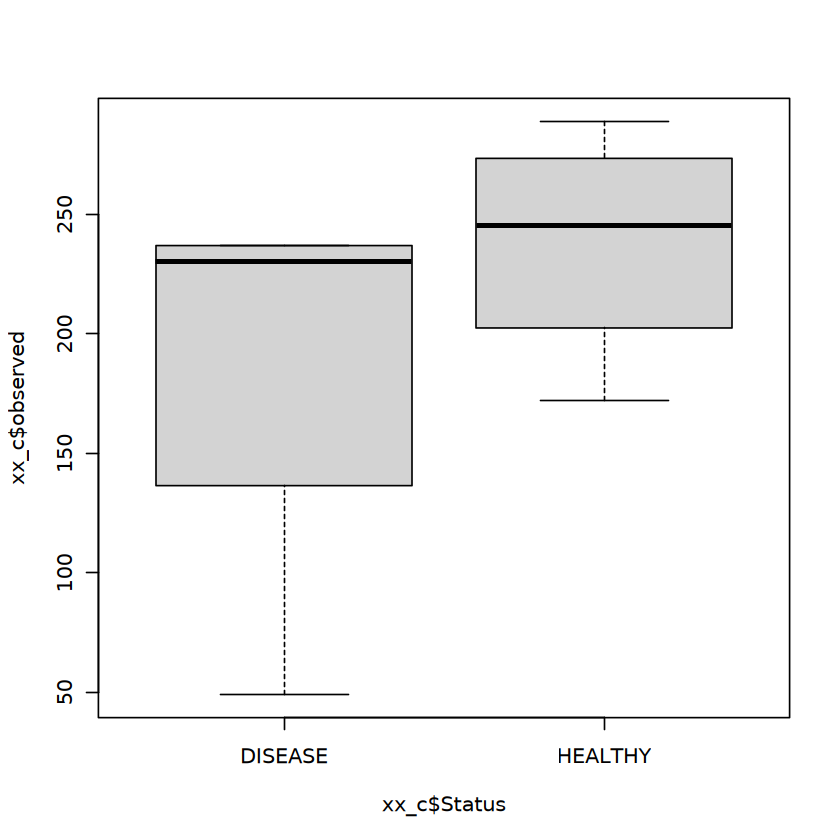

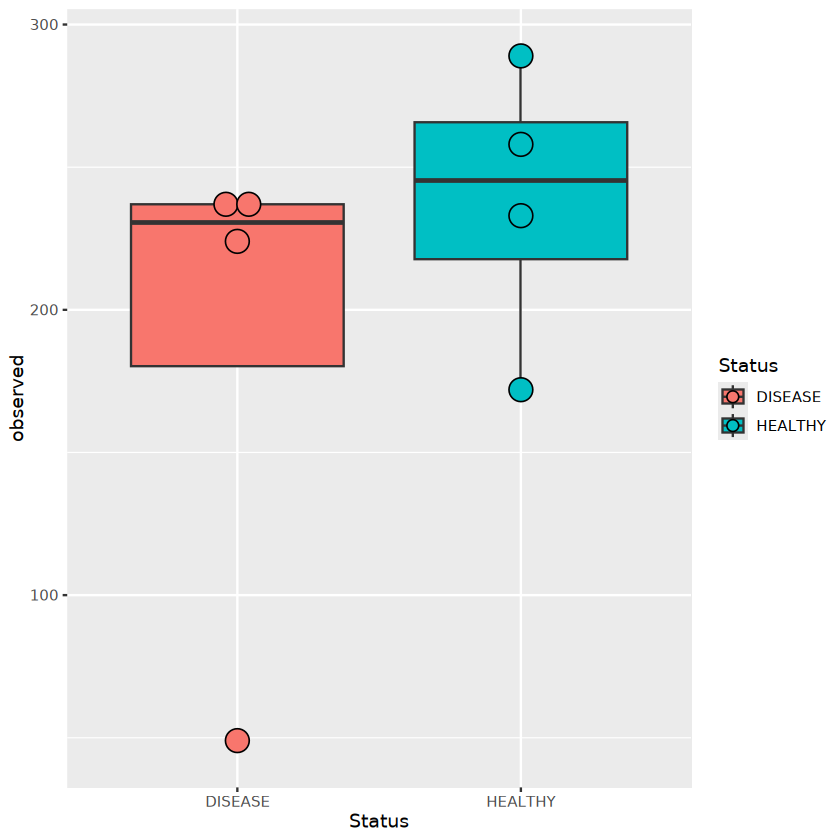

In [37]:
### observed
wilcox.test(xx_c$observed ~ xx_c$Status)
boxplot(xx_c$observed ~ xx_c$Status)
ggplot(xx_c, aes(x=Status, y=observed, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center')


	Wilcoxon rank sum exact test

data:  xx_c$diversity_shannon by xx_c$Status
W = 4, p-value = 0.3429
alternative hypothesis: true location shift is not equal to 0


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


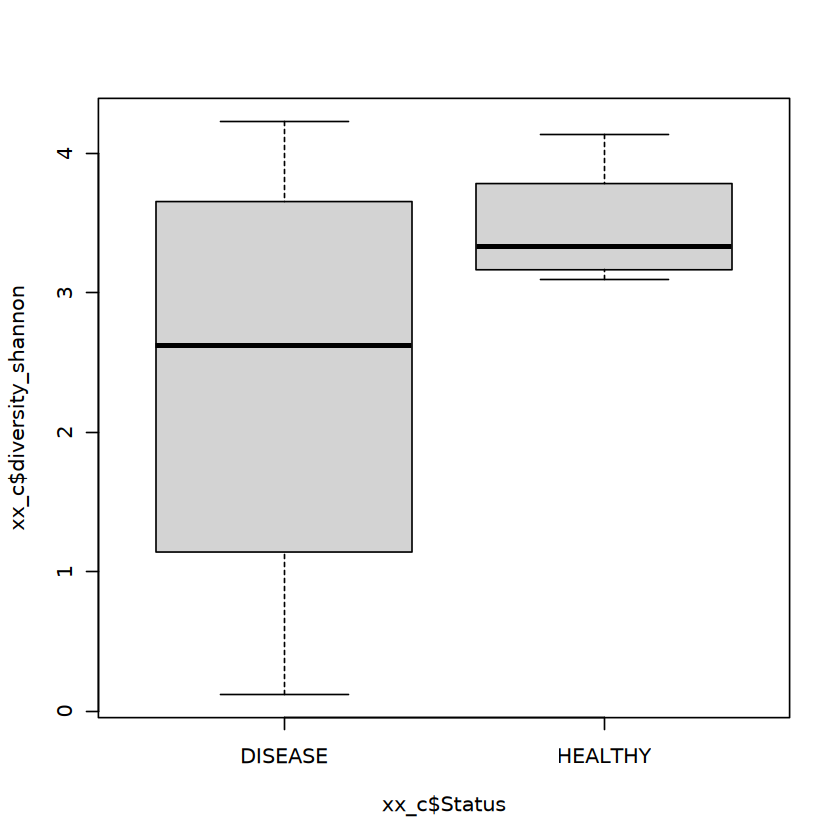

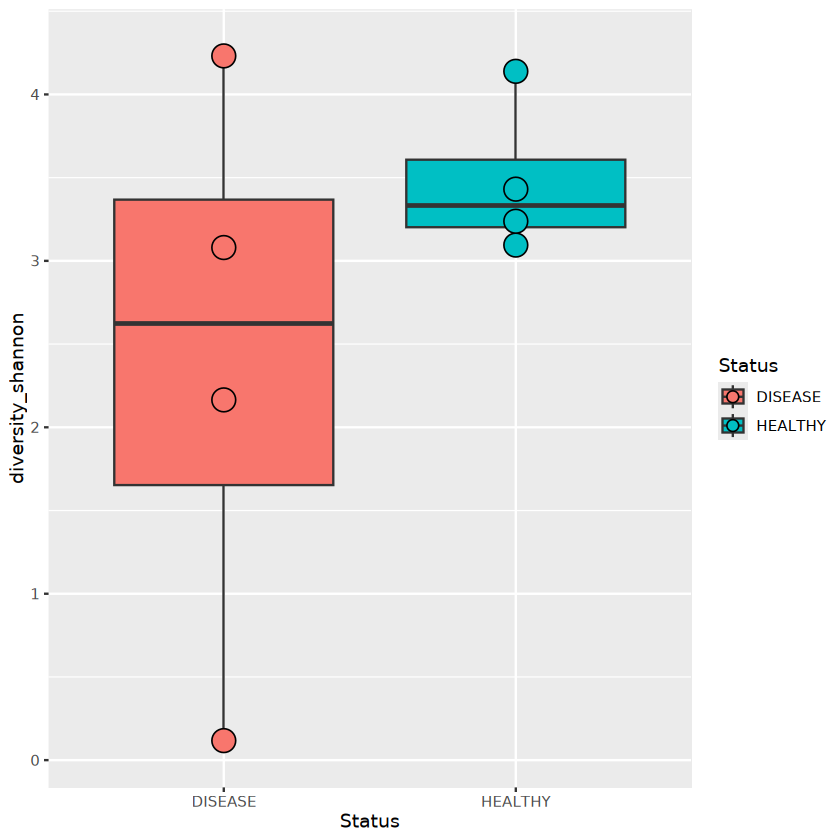

In [38]:
### diversity_shannon
wilcox.test(xx_c$diversity_shannon ~ xx_c$Status)
boxplot(xx_c$diversity_shannon ~ xx_c$Status)
ggplot(xx_c, aes(x=Status, y=diversity_shannon, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center')


	Wilcoxon rank sum exact test

data:  xx_c$diversity_inverse_simpson by xx_c$Status
W = 5, p-value = 0.4857
alternative hypothesis: true location shift is not equal to 0


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


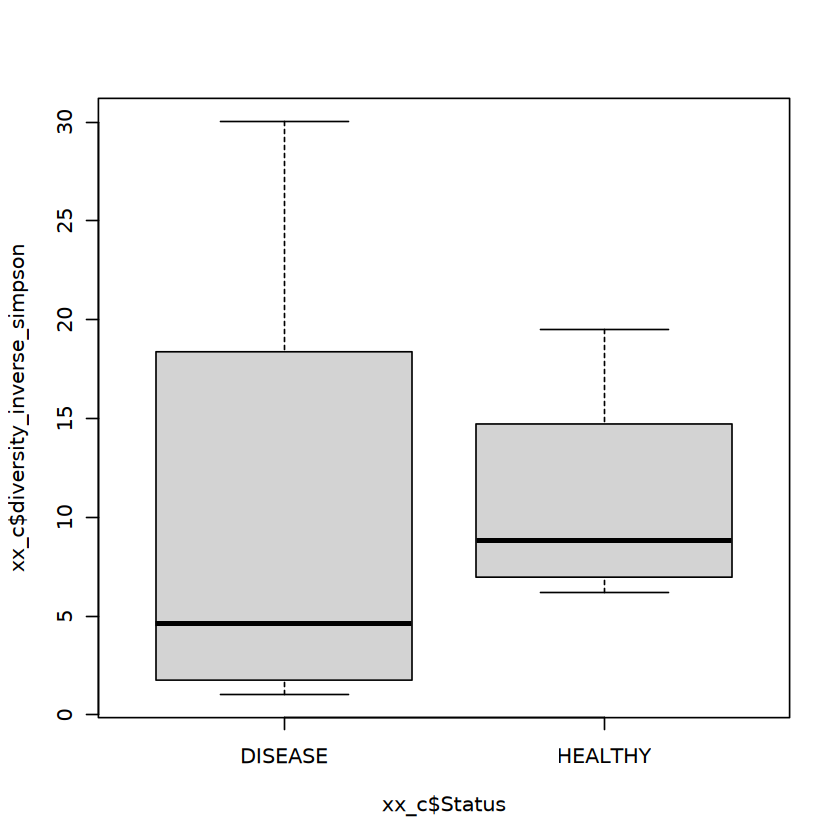

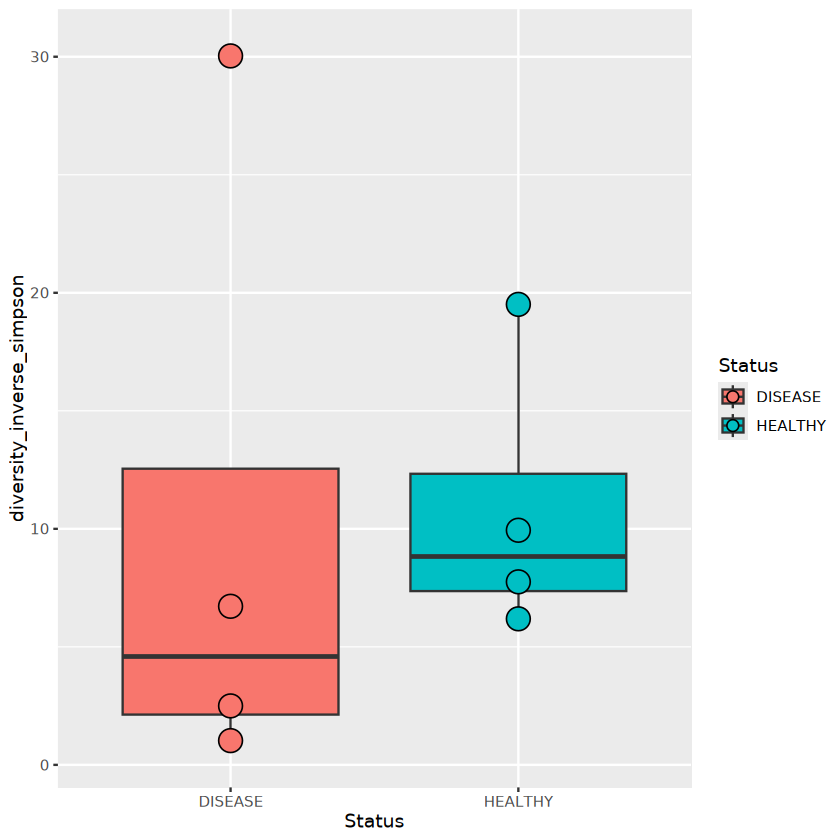

In [39]:
### diversity_inverse_simpson
wilcox.test(xx_c$diversity_inverse_simpson ~ xx_c$Status)
boxplot(xx_c$diversity_inverse_simpson ~ xx_c$Status)
ggplot(xx_c, aes(x=Status, y=diversity_inverse_simpson, fill = Status)) + 
  geom_boxplot()+
  geom_dotplot(binaxis='y', stackdir='center')

### Core microbiota

In [40]:
# Transform to compositional abundances
pseq.rel <- microbiome::transform(ps, "compositional")

In [41]:
# Pick the core (>0.1% relative abundance in >50% of the samples)
pseq.core <- core(pseq.rel, detection = 0.1/100, prevalence = 50/100)
pseq.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30 taxa and 12 samples ]
sample_data() Sample Data:       [ 12 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 30 taxa by 7 taxonomic ranks ]

In [42]:
# Core with compositionals:
prevalences <- seq(.05, 1, .05)

In [43]:
detections <- round(10^seq(log10(5e-3), log10(.2), length = 10), 3)

In [44]:
p <- plot_core(pseq.rel, plot.type = "heatmap",
               prevalences = prevalences, detections = detections, min.prevalence = 0.5) +
  xlab("Detection Threshold (Relative Abundance)") +
  theme(axis.text.x = element_text(size = 9))

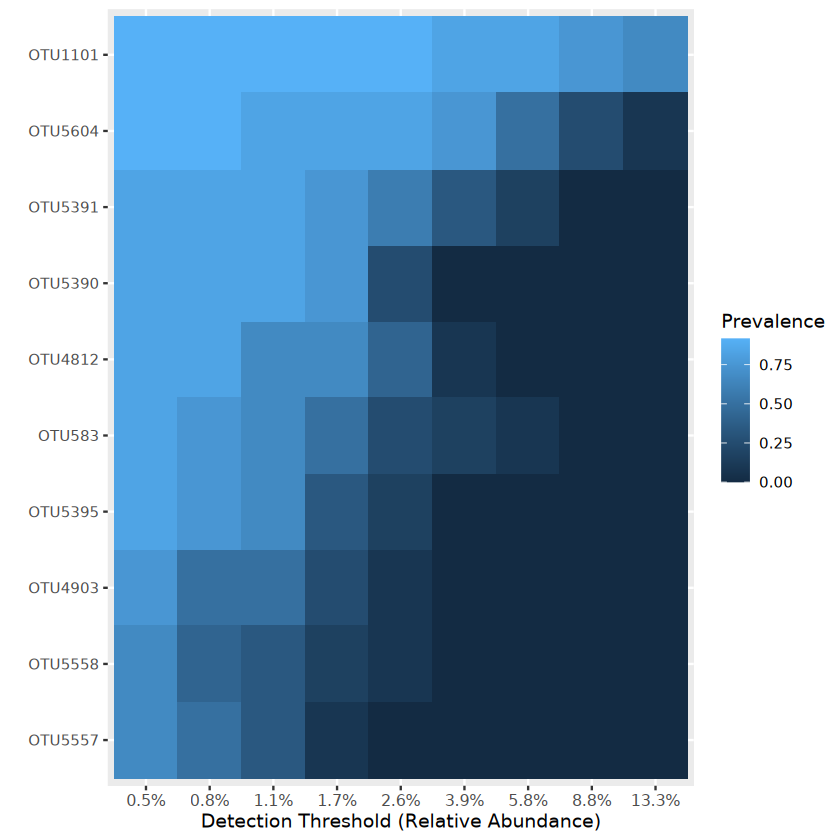

In [45]:
print(p)